# 1. Problem Identification

## Research Objectives
**Goal:** Detect driver drowsiness using images captured from a Raspberry Pi camera.

**The SVM classifier must identify:**
- **Drowsy state**: Eye closure, yawning, head down, slow blink, etc.
- **Non-drowsy state**: Alert driver.

**The system must handle variations:**
- Black & White images (Night vision/IR)
- Color images (Daytime)
- With glasses / Without glasses

**Constraints:**
- Must run efficiently on Raspberry Pi 4 (limited resources).

# 2. Understanding the Dataset

## 2.1 Dataset Structure
The dataset is organized into four primary conditions across two main classes (Drowsy vs Non-Drowsy):

| State | Glasses | Image Type |
| :--- | :--- | :--- |
| Drowsy | With glasses | BW/Color |
| Drowsy | Without glasses | BW/Color |
| Non-drowsy | With glasses | BW/Color |
| Non-drowsy | Without glasses | BW/Color |

## 2.2 Dataset Requirements
- **Uniform image size**: Resize to consistent pixel dimensions (e.g., 224x224).
- **Naming conventions**: Metadata (glasses, color) preserved in filenames.
- **Channel conversion**: Convert to grayscale for SVM feature extraction (HOG/LBP).

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Configuration Constants
DATASET_PATH = r"c:\Users\SAHAN\Desktop\SVM Model\dataset_split"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

IMG_SIZE = (224, 224)  # Resize target

print("Configuration Set:")
print(f"Dataset Directory: {DATASET_PATH}")
print(f"Image Target Size: {IMG_SIZE}")

Configuration Set:
Dataset Directory: c:\Users\SAHAN\Desktop\SVM Model\dataset_split
Image Target Size: (224, 224)


# 3. Exploratory Data Analysis (EDA)
Performing EDA to understand the dataset characteristics before training.

## 3.1 Dataset Overview
- Count images per class
- Check for class imbalances
- Display random samples
- Visualize pixel histograms
- Check resolution variance

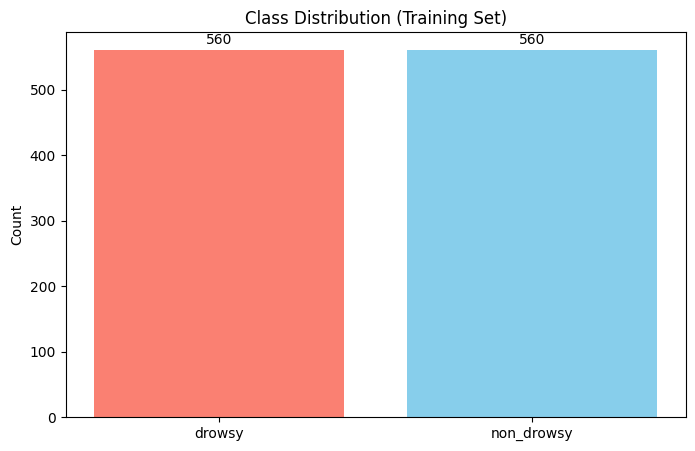

In [2]:
def analyze_class_distribution(base_path):
    categories = ['drowsy', 'non_drowsy']
    counts = {}
    for cat in categories:
        path = os.path.join(base_path, cat)
        counts[cat] = len(os.listdir(path))
    
    plt.figure(figsize=(8, 5))
    plt.bar(counts.keys(), counts.values(), color=['salmon', 'skyblue'])
    plt.title('Class Distribution (Training Set)')
    plt.ylabel('Count')
    for i, v in enumerate(counts.values()):
        plt.text(i, v + 10, str(v), ha='center')
    plt.show()
    return counts

train_counts = analyze_class_distribution(TRAIN_PATH)


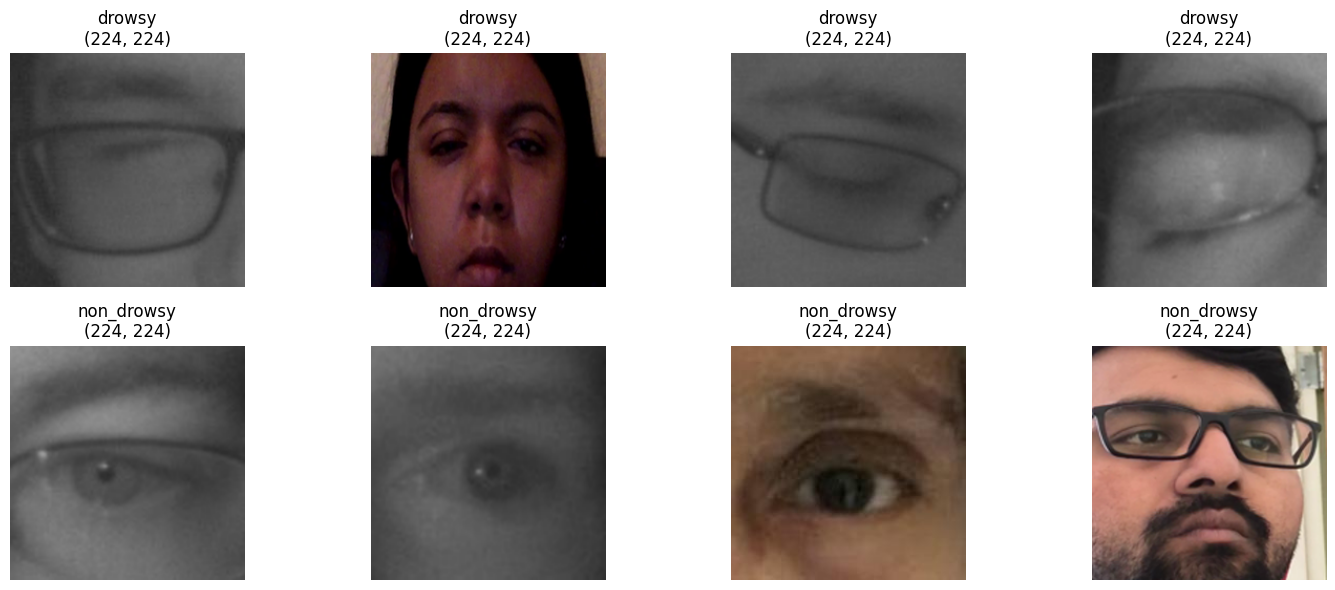

In [3]:
def visualize_random_samples(base_path, samples_per_class=4):
    categories = ['drowsy', 'non_drowsy']
    plt.figure(figsize=(15, 6))
    
    for idx, cat in enumerate(categories):
        path = os.path.join(base_path, cat)
        files = os.listdir(path)
        selected = np.random.choice(files, samples_per_class, replace=False)
        
        for i, img_name in enumerate(selected):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(2, samples_per_class, idx * samples_per_class + i + 1)
            plt.imshow(img)
            plt.title(f"{cat}\n{img.shape[:2]}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_random_samples(TRAIN_PATH)

In [4]:
def check_resolutions(base_path):
    resolutions = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    resolutions.append(img.shape[:2])
    
    resolutions = np.array(resolutions)
    unique_res = np.unique(resolutions, axis=0)
    print(f"Unique Image Resolutions found: {len(unique_res)}")
    if len(unique_res) > 5:
        print("Top 5 resolutions:", unique_res[:5])
    else:
        print("Resolutions:", unique_res)

check_resolutions(TRAIN_PATH)

Unique Image Resolutions found: 1
Resolutions: [[224 224]]


## 3.2 Statistical EDA
- Mean pixel intensity
- Standard deviation
- Compare BW vs Color distributions

Overall Mean Intensity: 88.00
Overall Std Dev: 28.05


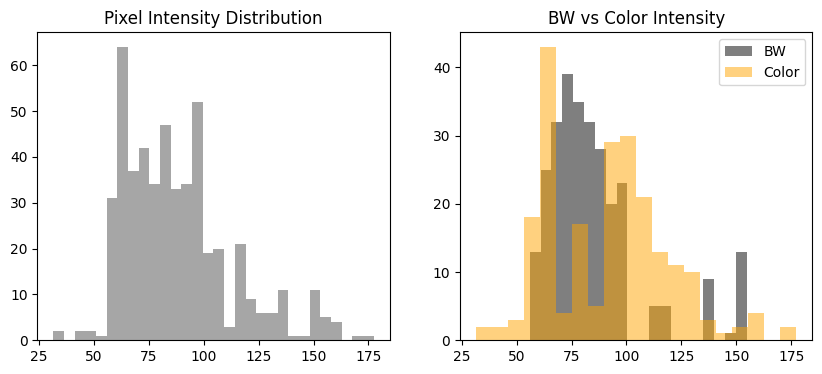

In [5]:
def calc_pixel_stats(base_path):
    pixel_means = []
    pixel_stds = []
    bw_intensities = []
    col_intensities = []
    
    # Sampling to avoid memory overload if dataset is huge
    sample_count = 0
    max_samples = 500 
    
    for root, _, files in os.walk(base_path):
        for file in files:
            if sample_count >= max_samples: break
            
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            if img is not None:
                mean_val = np.mean(img)
                std_val = np.std(img)
                pixel_means.append(mean_val)
                pixel_stds.append(std_val)
                
                # Infer type from content or filename
                # Filename has 'bw_' or 'col_' prefix from split script
                if 'bw_' in file:
                    bw_intensities.append(mean_val)
                elif 'col_' in file:
                    col_intensities.append(mean_val)
                
                sample_count += 1
    
    print(f"Overall Mean Intensity: {np.mean(pixel_means):.2f}")
    print(f"Overall Std Dev: {np.mean(pixel_stds):.2f}")
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pixel_means, bins=30, color='gray', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    
    plt.subplot(1, 2, 2)
    plt.hist(bw_intensities, bins=20, alpha=0.5, label='BW', color='black')
    plt.hist(col_intensities, bins=20, alpha=0.5, label='Color', color='orange')
    plt.title('BW vs Color Intensity')
    plt.legend()
    plt.show()

calc_pixel_stats(TRAIN_PATH)

## 3.3 Metadata Checks
- Brightness Analysis
- Blur Detection (Laplacian Variance)

Avg Brightness: 103.48
Avg Sharpness (Laplacian Var): 65.68


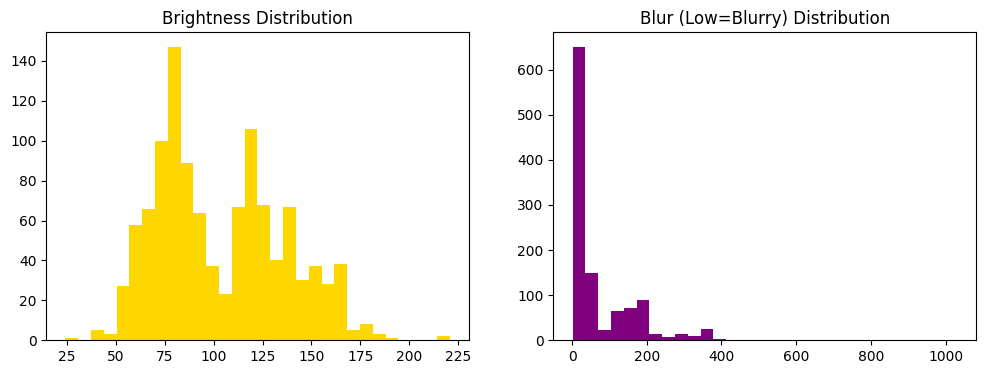

In [6]:
def check_quality(base_path):
    blur_scores = []
    brightness_scores = []
    
    for root, _, files in os.walk(base_path):
        for file in files:
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            if img is not None:
                # Brightness (HSV Value channel)
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                brightness = np.mean(hsv[:,:,2])
                brightness_scores.append(brightness)
                
                # Blur (Laplacian Variance)
                # Convert to gray for focus measure
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                variance = cv2.Laplacian(gray, cv2.CV_64F).var()
                blur_scores.append(variance)
    
    print(f"Avg Brightness: {np.mean(brightness_scores):.2f}")
    print(f"Avg Sharpness (Laplacian Var): {np.mean(blur_scores):.2f}")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(brightness_scores, bins=30, color='gold')
    plt.title('Brightness Distribution')
    
    plt.subplot(1, 2, 2)
    plt.hist(blur_scores, bins=30, color='purple')
    plt.title('Blur (Low=Blurry) Distribution')
    plt.show()

check_quality(TRAIN_PATH)

# 4. Feature Engineering / Feature Encoding

SVM cannot use raw images directly as they are high-dimensional.
We will extract features using **HOG (Histogram of Oriented Gradients)** and **LBP (Local Binary Patterns)**.

**Strategy:**
- **HOG**: Captures edges, eye shapes, and mouth opening.
- **LBP**: Captures texture (good for BW images).
- **Combination**: Concatenate HOG + LBP vectors for best accuracy.

In [7]:
from skimage.feature import hog, local_binary_pattern
from skimage import exposure

# Feature Parameters
# HOG
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)

# LBP
LBP_POINTS = 24
LBP_RADIUS = 3
LBP_METHOD = 'uniform'

In [8]:
def extract_hog_features(image):
    # Image must be grayscale
    fd, hog_image = hog(image, orientations=HOG_ORIENTATIONS, 
                        pixels_per_cell=HOG_PIXELS_PER_CELL, 
                        cells_per_block=HOG_CELLS_PER_BLOCK, 
                        visualize=True)
    return fd, hog_image

def extract_lbp_features(image):
    # LBP returns an image-sized array, we need a histogram as feature vector
    lbp = local_binary_pattern(image, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    
    # Calculate histogram
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist, lbp

def extract_combined_features(image):
    hog_feats, _ = extract_hog_features(image)
    lbp_feats, _ = extract_lbp_features(image)
    
    # Concatenate
    combined = np.hstack((hog_feats, lbp_feats))
    return combined

## 4.1 Feature Visualization
Visualizing HOG and LBP on a sample image to verify they capture relevant details.

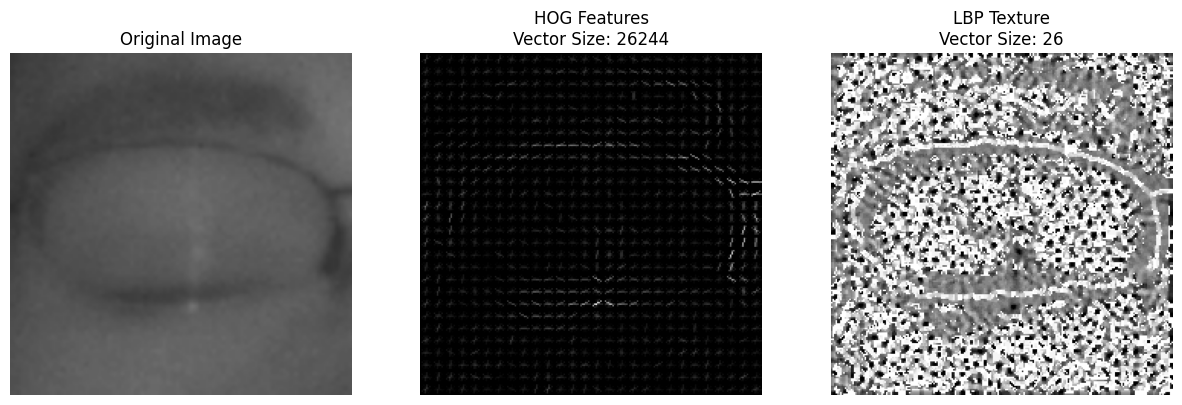

Combined Feature Vector Size: 26270


In [9]:
def visualize_features(base_path, category='drowsy'):
    path = os.path.join(base_path, category)
    img_name = os.listdir(path)[0]
    img_path = os.path.join(path, img_name)
    
    # Preprocess (Read + Resize + Gray)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Extract
    hog_fd, hog_img = extract_hog_features(gray)
    lbp_hist, lbp_img = extract_lbp_features(gray)
    
    # Visualize
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Rescale HOG for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
    ax2.imshow(hog_image_rescaled, cmap='gray')
    ax2.set_title(f'HOG Features\nVector Size: {len(hog_fd)}')
    ax2.axis('off')
    
    ax3.imshow(lbp_img, cmap='gray')
    ax3.set_title(f'LBP Texture\nVector Size: {len(lbp_hist)}')
    ax3.axis('off')
    
    plt.show()
    print(f"Combined Feature Vector Size: {len(hog_fd) + len(lbp_hist)}")

visualize_features(TRAIN_PATH)

# 5. Data Preprocessing Pipeline

Now we will apply the feature extraction to the entire dataset.

**Steps:**
1.  **Iterate** through Train, Validation, and Test folders.
2.  **Preprocess**: Resize (224x224) -> Grayscale -> Normalize.
3.  **Extract**: Compute HOG + LBP features.
4.  **Label Encode**: Non-drowsy = 0, Drowsy = 1.
5.  **Structure**: Create X (features) and y (labels) arrays for each split.

In [10]:
import time
from sklearn.utils import shuffle

In [11]:
def load_and_preprocess_data(base_path, split_name):
    print(f"Processing {split_name} data...")
    start_time = time.time()
    
    features = []
    labels = []
    
    # Label Mapping: 0 = non-drowsy, 1 = drowsy
    label_map = {'non_drowsy': 0, 'drowsy': 1}
    
    for category, label in label_map.items():
        cat_path = os.path.join(base_path, category)
        if not os.path.exists(cat_path):
            continue
            
        for file in os.listdir(cat_path):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(cat_path, file)
                
                # 1. Read and Resize
                img = cv2.imread(img_path)
                img = cv2.resize(img, IMG_SIZE)
                
                # 2. Grayscale
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # 3. Extract Features (HOG + LBP)
                # Note: Normalization is handled implicitly in HOG (block norm) and LBP (histogram density)
                feats = extract_combined_features(gray)
                
                features.append(feats)
                labels.append(label)
    
    # Convert to numpy arrays
    X = np.array(features)
    y = np.array(labels)
    
    # Shuffle to avoid sequential bias
    X, y = shuffle(X, y, random_state=42)
    
    print(f"  Finished {split_name}: {len(X)} samples. Shape: {X.shape}. Time: {time.time() - start_time:.2f}s")
    return X, y

# Execute Loading
X_train, y_train = load_and_preprocess_data(TRAIN_PATH, 'Train')
X_val, y_val = load_and_preprocess_data(VAL_PATH, 'Validation')
X_test, y_test = load_and_preprocess_data(TEST_PATH, 'Test')

Processing Train data...
  Finished Train: 1120 samples. Shape: (1120, 26270). Time: 128.44s
Processing Validation data...
  Finished Validation: 240 samples. Shape: (240, 26270). Time: 19.97s
Processing Test data...
  Finished Test: 240 samples. Shape: (240, 26270). Time: 18.59s


## 5.1 Verify Data Shapes
Checking the dimensions of our feature matrices.

In [12]:
print("Final Dataset Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

print(f"\nClass Balance in Train: Drowsy(1)={np.sum(y_train==1)}, Non-Drowsy(0)={np.sum(y_train==0)}")

Final Dataset Shapes:
X_train: (1120, 26270), y_train: (1120,)
X_val:   (240, 26270), y_val:   (240,)
X_test:  (240, 26270), y_test:  (240,)

Class Balance in Train: Drowsy(1)=560, Non-Drowsy(0)=560


# 6. Model Building (SVM)

## 6.1 Select SVM Kernel
We proceed with the **RBF (Radial Basis Function)** kernel as it generally provides the best performance for image classification tasks with complex decision boundaries.

**Kernel Selection Guide:**
- **RBF**: Best general performance (Selected).
- **Linear**: Faster but less accurate.
- **Poly**: Not recommended for this use case.

## 6.2 Hyperparameter Tuning
We will use **GridSearchCV** to find the optimal values for:
- **C (Regularization)**: Controls the trade-off between smooth decision boundary and classifying training points correctly.
- **gamma (Kernel Coefficient)**: Defines how far the influence of a single training example reaches.

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [14]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Initialize SVM model
svm = SVC(probability=True) # probability=True needed for later analysis if required

# Initialize GridSearchCV
print("Initializing Grid Search with RBF Kernel...")
grid = GridSearchCV(
    estimator=svm, 
    param_grid=param_grid, 
    refit=True,     # Automatically refit the best model on the whole train set
    verbose=3,      # Higher output to monitor progress
    cv=3            # 3-Fold Cross Validation
)

print("Model build complete. Ready for training.")

Initializing Grid Search with RBF Kernel...
Model build complete. Ready for training.


# 7. Model Training

**Procedure:**
1.  **Fit** the SVM on the training data (`X_train`) to tune hyperparameters.
2.  **Validate** performance on the validation set (`X_val`).
3.  **Retrain** the best model on Combined (Train + Validation) data to maximize learning before final testing.

In [15]:
print("Starting Grid Search Training... (This may take a few minutes)")
start_time = time.time()

# Fit the grid search to the data
grid.fit(X_train, y_train)

print(f"Training completed in {time.time() - start_time:.2f} seconds.")

Starting Grid Search Training... (This may take a few minutes)
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.957 total time= 6.5min
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.499 total time= 5.2min
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.499 total time= 4.7min
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.535 total time= 4.6min
[CV 2/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.499 total time= 4.6min
[CV 3/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.499 total time= 4.3min
[CV 1/3] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.687 total time= 4.7min
[CV 2/3] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.539 total time= 4.2min
[CV 3/3] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.544 total time= 4.7min
[CV 1/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.837 total time= 4.4min
[CV 2/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.649 tota

In [16]:
# Print best parameters and score
print("Best Hyperparameters found:")
print(grid.best_params_)
print(f"Best Cross-Validation Accuracy: {grid.best_score_:.4f}")

Best Hyperparameters found:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9571


## 7.1 Validation on Hold-out Set
Evaluating the optimized model on the validation set to check for overfitting.

In [17]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on Validation Set
y_val_pred = grid.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=['Non-Drowsy', 'Drowsy']))

Validation Accuracy: 0.9583

Classification Report (Validation):
              precision    recall  f1-score   support

  Non-Drowsy       0.97      0.94      0.96       120
      Drowsy       0.94      0.97      0.96       120

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



## 7.2 Retraining on Combined Data
Now that we have the best hyperparameters, we combine Training and Validation sets and retrain the final model to use all available data.

In [18]:
# Combine Train and Validation sets
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))

print(f"Combined Training Data Shape: {X_combined.shape}")

# Get the best estimator from grid search
final_model = grid.best_estimator_

# Retrain
print("Retraining final model on combined data...")
final_model.fit(X_combined, y_combined)
print("Final model training complete.")

Combined Training Data Shape: (1360, 26270)
Retraining final model on combined data...
Final model training complete.


# 8. Model Evaluation & Interpretation

We will evaluating the model using:
1.  **Quantitative Metrics**: Accuracy, Precision, Recall, F1-score, ROC-AUC.
2.  **Confusion Matrix**: To see false positives/negatives.
3.  **Sub-group Analysis**: Checking performance on "Glasses" vs "No Glasses".
4.  **Qualitative Analysis**: Visualizing misclassified examples.
5.  **Interpretation**: PCA visualization of the decision boundary.

Predicting on Test Set...

--- Final Test Set Evaluation ---

              precision    recall  f1-score   support

  Non-Drowsy       0.96      0.97      0.96       120
      Drowsy       0.97      0.96      0.96       120

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



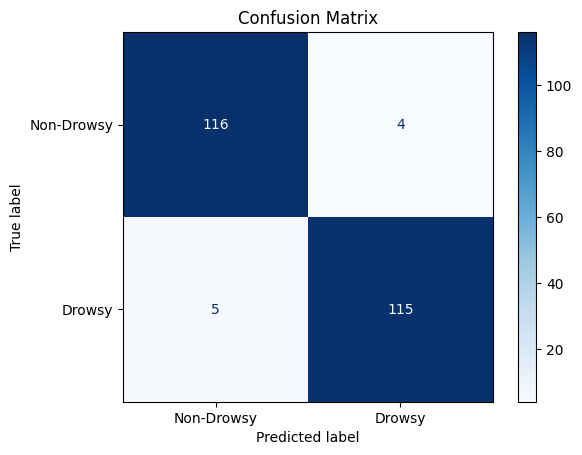

In [19]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

# Predict on Test Set
print("Predicting on Test Set...")
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

# Classification Report
print("\n--- Final Test Set Evaluation ---\n")
print(classification_report(y_test, y_test_pred, target_names=['Non-Drowsy', 'Drowsy']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Drowsy', 'Drowsy'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

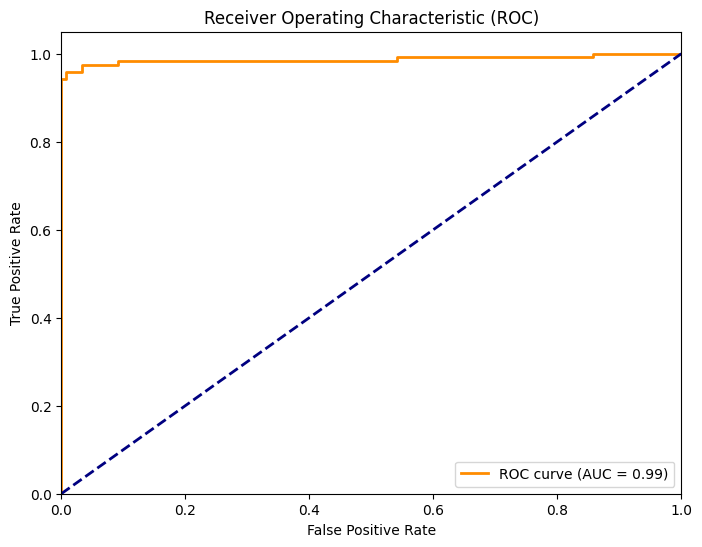

In [20]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 8.1 Class-level Performance (Glasses vs No Glasses)
To perform this analysis, we reload the test set preserving metadata.

In [21]:
def evaluate_subgroups(base_path, model):
    print("Evaluating Sub-groups (Glasses vs No Glasses)...")
    
    subgroup_data = {'glasses': {'y_true': [], 'y_pred': []}, 
                     'no_glasses': {'y_true': [], 'y_pred': []}}
    
    label_map = {'non_drowsy': 0, 'drowsy': 1}
    
    for category, label in label_map.items():
        cat_path = os.path.join(base_path, category)
        for file in os.listdir(cat_path):
            if file.lower().endswith(('.jpg', '.png')):
                # Determine subgroup from filename
                # Filename format from split: 'bw_glass_...' or 'col_no_glass_...'
                is_glasses = 'glass' in file and 'no_glass' not in file
                subgroup_key = 'glasses' if is_glasses else 'no_glasses'
                
                # Process
                img = cv2.imread(os.path.join(cat_path, file))
                img = cv2.resize(img, IMG_SIZE)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                feats = extract_combined_features(gray)
                
                # Predict
                pred = model.predict([feats])[0]
                
                subgroup_data[subgroup_key]['y_true'].append(label)
                subgroup_data[subgroup_key]['y_pred'].append(pred)
    
    # Report
    for key, data in subgroup_data.items():
        if data['y_true']:
            acc = accuracy_score(data['y_true'], data['y_pred'])
            print(f"\nAccuracy for {key.upper()}: {acc:.4f} (n={len(data['y_true'])})")
            print(classification_report(data['y_true'], data['y_pred'], target_names=['Non-Drowsy', 'Drowsy']))

evaluate_subgroups(TEST_PATH, final_model)

Evaluating Sub-groups (Glasses vs No Glasses)...

Accuracy for GLASSES: 0.9520 (n=125)
              precision    recall  f1-score   support

  Non-Drowsy       0.95      0.95      0.95        63
      Drowsy       0.95      0.95      0.95        62

    accuracy                           0.95       125
   macro avg       0.95      0.95      0.95       125
weighted avg       0.95      0.95      0.95       125


Accuracy for NO_GLASSES: 0.9739 (n=115)
              precision    recall  f1-score   support

  Non-Drowsy       0.97      0.98      0.97        57
      Drowsy       0.98      0.97      0.97        58

    accuracy                           0.97       115
   macro avg       0.97      0.97      0.97       115
weighted avg       0.97      0.97      0.97       115



## 8.2 Qualitative Evaluation (Misclassified Samples)
Visualizing images that the model got wrong to understand failure modes.

Displaying 5 misclassified samples:


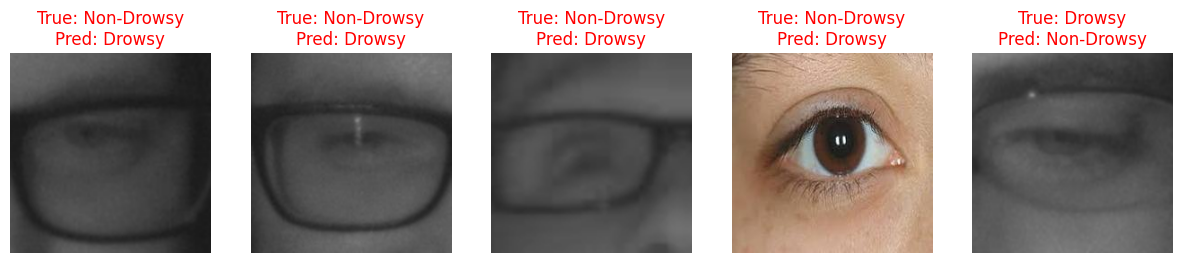

In [22]:
def visualize_misclassified(base_path, model, num_show=5):
    misclassified = []
    
    label_map = {'non_drowsy': 0, 'drowsy': 1}
    classes = ['Non-Drowsy', 'Drowsy']
    
    for category, label in label_map.items():
        cat_path = os.path.join(base_path, category)
        for file in os.listdir(cat_path):
            img_path = os.path.join(cat_path, file)
            img = cv2.imread(img_path)
            if img is None: continue
            
            # Predict
            img_resized = cv2.resize(img, IMG_SIZE)
            gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            feats = extract_combined_features(gray)
            pred = model.predict([feats])[0]
            
            if pred != label:
                misclassified.append((img, label, pred, file))
                if len(misclassified) >= num_show: break
        if len(misclassified) >= num_show: break
    
    if not misclassified:
        print("No misclassified samples found in this mini-batch!")
        return
    
    print(f"Displaying {len(misclassified)} misclassified samples:")
    plt.figure(figsize=(15, 3))
    for i, (img, true_lbl, pred_lbl, name) in enumerate(misclassified):
        plt.subplot(1, num_show, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {classes[true_lbl]}\nPred: {classes[pred_lbl]}", color='red')
        plt.axis('off')
    plt.show()

visualize_misclassified(TEST_PATH, final_model)

## 8.3 Interpretation: Decision Boundary Visualization (PCA)
Since our feature space is high-dimensional (thousands of features), we use PCA to reduce it to 2D to visualize how the SVM separates the classes.

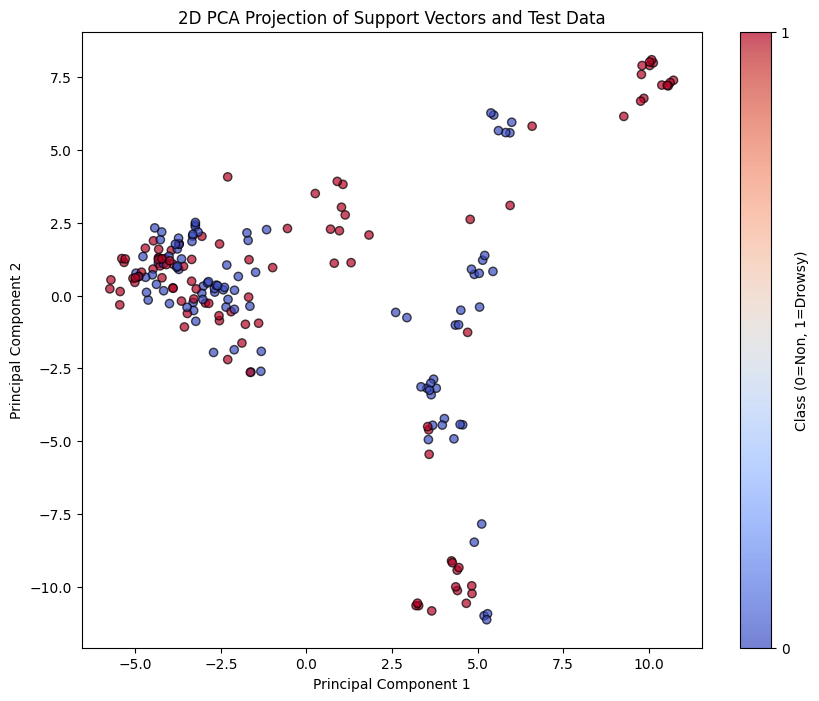

In [23]:
from sklearn.decomposition import PCA

# Sample a subset for visualization to keep it fast
idx = np.random.choice(len(X_test), 200, replace=False)
X_viz = X_test[idx]
y_viz = y_test[idx]

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_viz)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_viz, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label='Class (0=Non, 1=Drowsy)')
plt.title('2D PCA Projection of Support Vectors and Test Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 9. Model Saving

We will save the trained model and valid configuration parameters for deployment (e.g., on Raspberry Pi).
We use `joblib` for efficient model serialization.

In [24]:
import joblib

# 1. Define configurations to save
hog_params = {
    'orientations': HOG_ORIENTATIONS,
    'pixels_per_cell': HOG_PIXELS_PER_CELL,
    'cells_per_block': HOG_CELLS_PER_BLOCK,
    'lbp_points': LBP_POINTS,
    'lbp_radius': LBP_RADIUS,
    'image_size': IMG_SIZE
}

label_map = {
    'non_drowsy': 0, 
    'drowsy': 1,
    'classes': ['Non-Drowsy', 'Drowsy']
}

# 2. Save files
print("Saving model artifacts...")

# Save SVM Model
joblib.dump(final_model, 'svm_model.pkl')
print("- Saved 'svm_model.pkl'")

# Save HOG/Feature Parameters
joblib.dump(hog_params, 'hog_parameters.pkl')
print("- Saved 'hog_parameters.pkl'")

# Save Label Encoder
joblib.dump(label_map, 'label_encoder.pkl')
print("- Saved 'label_encoder.pkl'")

# Note on scaler.pkl: 
# Since we used HOG/LBP features which are self-normalized ( histograms summing to 1 or block-norm), 
# we did not fit an external StandardScaler. Thus 'scaler.pkl' is not needed for this specific pipeline.
print("Artifacts saved in current directory.")

Saving model artifacts...
- Saved 'svm_model.pkl'
- Saved 'hog_parameters.pkl'
- Saved 'label_encoder.pkl'
Artifacts saved in current directory.


In [25]:
# Verify files exist
files_to_check = ['svm_model.pkl', 'hog_parameters.pkl', 'label_encoder.pkl']
for f in files_to_check:
    if os.path.exists(f):
        print(f"[OK] {f} exists. Size: {os.path.getsize(f)/1024:.2f} KB")
    else:
        print(f"[MISSING] {f}")

[OK] svm_model.pkl exists. Size: 167078.28 KB
[OK] hog_parameters.pkl exists. Size: 0.13 KB
[OK] label_encoder.pkl exists. Size: 0.08 KB
